# **Determination of Air Quality by predicitng Benzene concentrations in the Atmosphere**

## 1. Loading Necessary Libraries

In [ ]:
#!pip install scienceplots
from joblib import dump
from sklearn.ensemble import RandomForestRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ConstantKernel,ExpSineSquared
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV,TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scienceplots
import scipy.stats as stats
import seaborn as sns
np.random.seed(70)
plt.rcParams["text.usetex"] = False
plt.style.use('science')


## 2. Loading of Dataset


---

NOTE: In the dataset all missing values were replaces with -200. I need to remove them

In [4]:
'''#Mount drive
from google.colab import drive
drive.mount('/content/drive')'''

"#Mount drive\nfrom google.colab import drive\ndrive.mount('/content/drive')"

In [370]:
df = pd.read_excel(r"C:\Users\Administrator\Downloads\air+quality\AirQualityUCI.xlsx")
df.shape

#let us save a copy
original = df.copy()
df.head()

Date      Time  CO(GT)  PT08.S1(CO)  NMHC(GT)   C6H6(GT)  \
0 2004-03-10  18:00:00     2.6      1360.00       150  11.881723   
1 2004-03-10  19:00:00     2.0      1292.25       112   9.397165   
2 2004-03-10  20:00:00     2.2      1402.00        88   8.997817   
3 2004-03-10  21:00:00     2.2      1375.50        80   9.228796   
4 2004-03-10  22:00:00     1.6      1272.25        51   6.518224   

   PT08.S2(NMHC)  NOx(GT)  PT08.S3(NOx)  NO2(GT)  PT08.S4(NO2)  PT08.S5(O3)  \
0        1045.50    166.0       1056.25    113.0       1692.00      1267.50   
1         954.75    103.0       1173.75     92.0       1558.75       972.25   
2         939.25    131.0       1140.00    114.0       1554.50      1074.00   
3         948.25    172.0       1092.00    122.0       1583.75      1203.25   
4         835.50    131.0       1205.00    116.0       1490.00      1110.00   

       T         RH        AH  
0  13.60  48.875001  0.757754  
1  13.30  47.700000  0.725487  
2  11.90  53.975000  0.750239  
3  11.00  60.000000  0.786713  
4  11.15  59.575001  0.788794

In [371]:
# In the experiment that produced our dataset the conventional fixed
# station provided reference concentration estimation for five different
# atmospheric pollutants which were tagged with (GT), however our focus is
# is on Benzene C6H6(GT) so we will drop all other targets

df.drop(columns= ['CO(GT)','NMHC(GT)','NOx(GT)','NO2(GT)'],inplace= True )
df.head()

Date      Time  PT08.S1(CO)   C6H6(GT)  PT08.S2(NMHC)  PT08.S3(NOx)  \
0 2004-03-10  18:00:00      1360.00  11.881723        1045.50       1056.25   
1 2004-03-10  19:00:00      1292.25   9.397165         954.75       1173.75   
2 2004-03-10  20:00:00      1402.00   8.997817         939.25       1140.00   
3 2004-03-10  21:00:00      1375.50   9.228796         948.25       1092.00   
4 2004-03-10  22:00:00      1272.25   6.518224         835.50       1205.00   

   PT08.S4(NO2)  PT08.S5(O3)      T         RH        AH  
0       1692.00      1267.50  13.60  48.875001  0.757754  
1       1558.75       972.25  13.30  47.700000  0.725487  
2       1554.50      1074.00  11.90  53.975000  0.750239  
3       1583.75      1203.25  11.00  60.000000  0.786713  
4       1490.00      1110.00  11.15  59.575001  0.788794

### Rename columns



In [372]:
df.columns

Index(['Date', 'Time', 'PT08.S1(CO)', 'C6H6(GT)', 'PT08.S2(NMHC)',
       'PT08.S3(NOx)', 'PT08.S4(NO2)', 'PT08.S5(O3)', 'T', 'RH', 'AH'],
      dtype='object')

In [373]:
# Renaming columns to intuitive names
# i need to rename these columns for them to make any sense
df.rename(columns= {"PT08.S1(CO)":"sensor_1(CO)",
                    'PT08.S2(NMHC)':"sensor_2(NMHC)",
                    'PT08.S3(NOx)': "sensor_3(NOx)",
                    'PT08.S4(NO2)': "sensor_4(NO2)",
                    'PT08.S5(O3)':"sensor_5(O3)",
                    "T":"temp",
                    "RH":"rel_humidity",
                    "AH":"abs_humidity",
                    "Date":'date',
                    "Time":'time'
                    }, inplace = True)
df.head()

date      time  sensor_1(CO)   C6H6(GT)  sensor_2(NMHC)  \
0 2004-03-10  18:00:00       1360.00  11.881723         1045.50   
1 2004-03-10  19:00:00       1292.25   9.397165          954.75   
2 2004-03-10  20:00:00       1402.00   8.997817          939.25   
3 2004-03-10  21:00:00       1375.50   9.228796          948.25   
4 2004-03-10  22:00:00       1272.25   6.518224          835.50   

   sensor_3(NOx)  sensor_4(NO2)  sensor_5(O3)   temp  rel_humidity  \
0        1056.25        1692.00       1267.50  13.60     48.875001   
1        1173.75        1558.75        972.25  13.30     47.700000   
2        1140.00        1554.50       1074.00  11.90     53.975000   
3        1092.00        1583.75       1203.25  11.00     60.000000   
4        1205.00        1490.00       1110.00  11.15     59.575001   

   abs_humidity  
0      0.757754  
1      0.725487  
2      0.750239  
3      0.786713  
4      0.788794

## 3. Exploratory Data Analysis
---


In [374]:
df.columns

Index(['date', 'time', 'sensor_1(CO)', 'C6H6(GT)', 'sensor_2(NMHC)',
       'sensor_3(NOx)', 'sensor_4(NO2)', 'sensor_5(O3)', 'temp',
       'rel_humidity', 'abs_humidity'],
      dtype='object')

In [375]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9357 entries, 0 to 9356
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   date            9357 non-null   datetime64[ns]
 1   time            9357 non-null   object        
 2   sensor_1(CO)    9357 non-null   float64       
 3   C6H6(GT)        9357 non-null   float64       
 4   sensor_2(NMHC)  9357 non-null   float64       
 5   sensor_3(NOx)   9357 non-null   float64       
 6   sensor_4(NO2)   9357 non-null   float64       
 7   sensor_5(O3)    9357 non-null   float64       
 8   temp            9357 non-null   float64       
 9   rel_humidity    9357 non-null   float64       
 10  abs_humidity    9357 non-null   float64       
dtypes: datetime64[ns](1), float64(9), object(1)
memory usage: 804.2+ KB


In [376]:
df.describe()

date  sensor_1(CO)     C6H6(GT)  \
count                           9357   9357.000000  9357.000000   
mean   2004-09-21 04:30:05.193972480   1048.869652     1.865576   
min              2004-03-10 00:00:00   -200.000000  -200.000000   
25%              2004-06-16 00:00:00    921.000000     4.004958   
50%              2004-09-21 00:00:00   1052.500000     7.886653   
75%              2004-12-28 00:00:00   1221.250000    13.636091   
max              2005-04-04 00:00:00   2039.750000    63.741476   
std                              NaN    329.817015    41.380154   

       sensor_2(NMHC)  sensor_3(NOx)  sensor_4(NO2)  sensor_5(O3)  \
count     9357.000000    9357.000000    9357.000000   9357.000000   
mean       894.475963     794.872333    1391.363266    974.951534   
min       -200.000000    -200.000000    -200.000000   -200.000000   
25%        711.000000     637.000000    1184.750000    699.750000   
50%        894.500000     794.250000    1445.500000    942.000000   
75%       1104.750000     960.250000    1662.000000   1255.250000   
max       2214.000000    2682.750000    2775.000000   2522.750000   
std        342.315902     321.977031     467.192382    456.922728   

              temp  rel_humidity  abs_humidity  
count  9357.000000   9357.000000   9357.000000  
mean      9.776600     39.483611     -6.837604  
min    -200.000000   -200.000000   -200.000000  
25%      10.950000     34.050000      0.692275  
50%      17.200000     48.550000      0.976823  
75%      24.075000     61.875000      1.296223  
max      44.600000     88.725000      2.231036  
std      43.203438     51.215645     38.976670

In [377]:
#let us compare the relationship between the measured gases from the sensors and the target benzene concentrations

measurement_from_sensors = ['sensor_1(CO)','sensor_2(NMHC)','sensor_3(NOx)','sensor_4(NO2)','sensor_5(O3)']
benzene = ['C6H6(GT)']
def plot_scatter(sensor):
    sns.scatterplot(data=df, x=sensor, y = 'C6H6(GT)',)
    plt.title(f"Scatter plot of C6H6(GT) against sensor {sensor}")
    return plt.show()

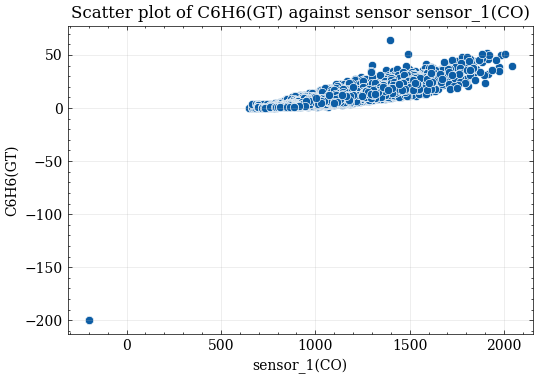

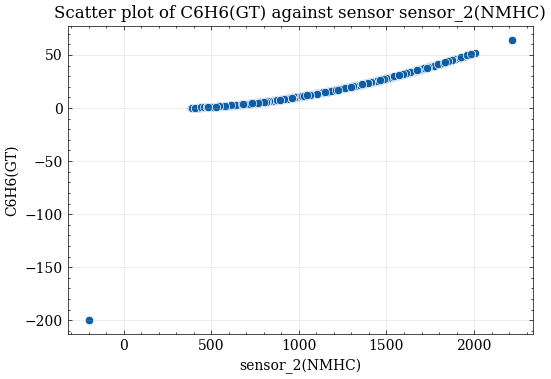

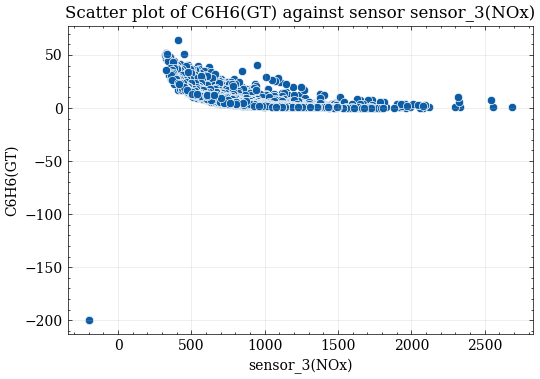

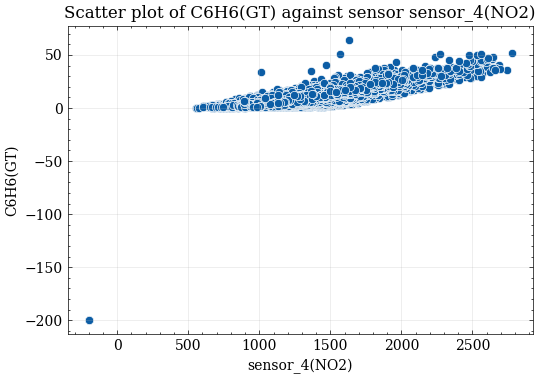

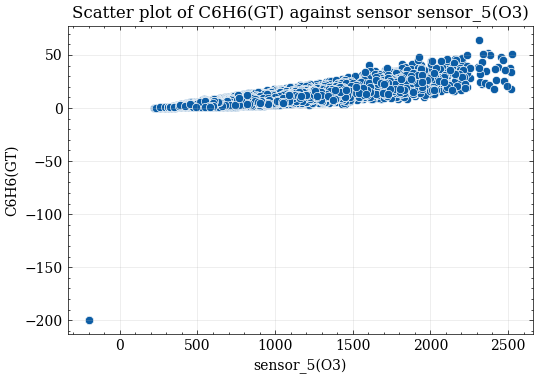

In [13]:
for sensor in measurement_from_sensors:
    plt.figure(figsize=(6,4))
    plt.grid(alpha= 0.3)
    plot_scatter(sensor)

In [378]:
def plot_histplot(col):
    """
    col: column you want to explore
    """
    plt.figure(figsize = (6,4))
    sns.histplot(data= df,x =col, kde= True)
    plt.grid(alpha= 0.3)
    return plt.show()


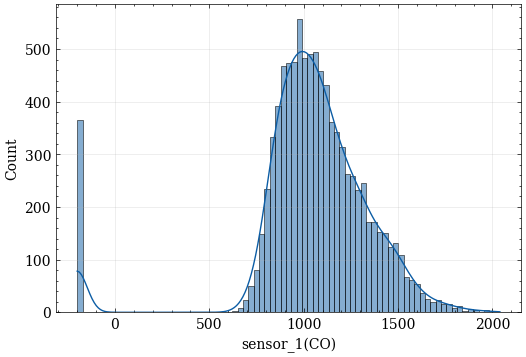

<Figure size 350x262.5 with 0 Axes>

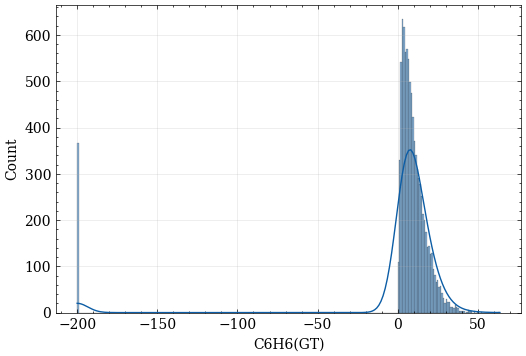

<Figure size 350x262.5 with 0 Axes>

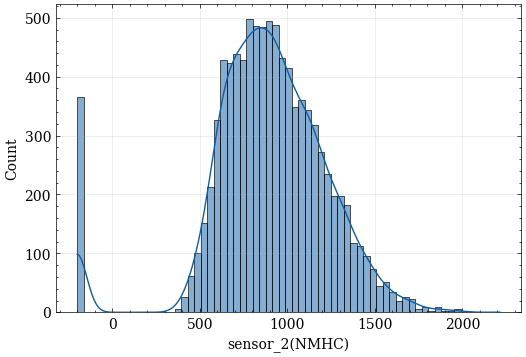

<Figure size 350x262.5 with 0 Axes>

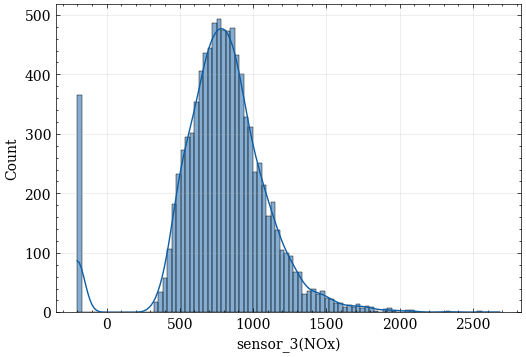

<Figure size 350x262.5 with 0 Axes>

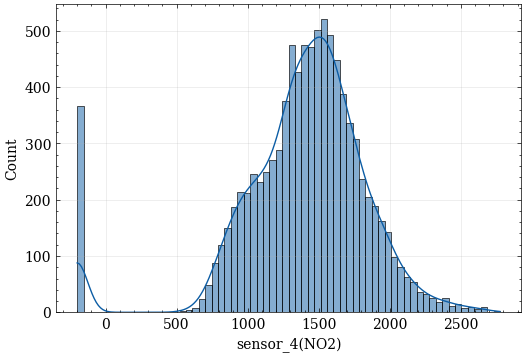

<Figure size 350x262.5 with 0 Axes>

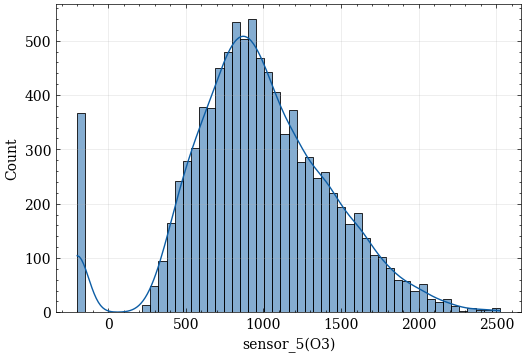

<Figure size 350x262.5 with 0 Axes>

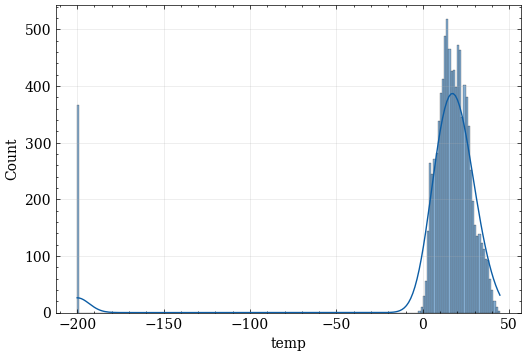

<Figure size 350x262.5 with 0 Axes>

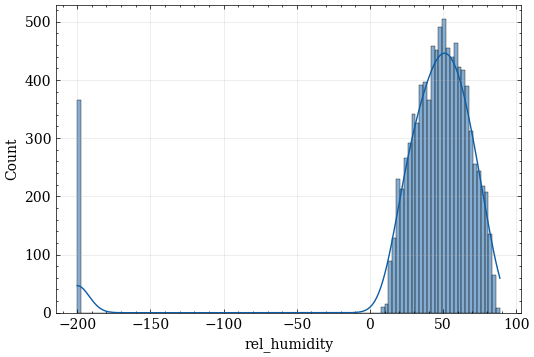

<Figure size 350x262.5 with 0 Axes>

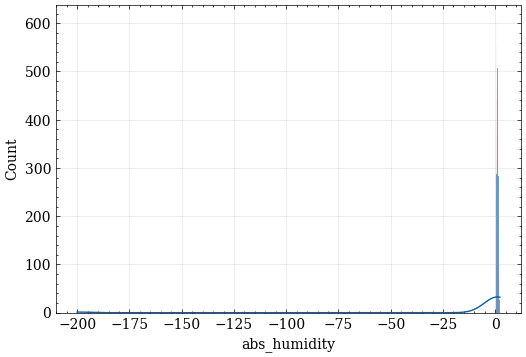

<Figure size 350x262.5 with 0 Axes>

In [379]:
for column in df.drop(columns=["date","time"]):
    plot_histplot(column)
    plt.savefig("Appendix_images.png")

#### Handling missing entries

---


 In the summary paper null entries were replaced with -200, and this entries are distorting the representations of our dataset.

 They will be removed.

In [16]:
df.isin([-200]).any(axis=1).sum()
# we have 366 rows with -200. They will be removed

366

In [17]:
rows_with_minus_200 = df[df.isin([-200]).any(axis=1)]
rows_with_minus_200

date      time  sensor_1(CO)  C6H6(GT)  sensor_2(NMHC)  \
524  2004-04-01  14:00:00        -200.0    -200.0          -200.0   
525  2004-04-01  15:00:00        -200.0    -200.0          -200.0   
526  2004-04-01  16:00:00        -200.0    -200.0          -200.0   
701  2004-04-08  23:00:00        -200.0    -200.0          -200.0   
702  2004-04-09  00:00:00        -200.0    -200.0          -200.0   
...         ...       ...           ...       ...             ...   
8111 2005-02-11  17:00:00        -200.0    -200.0          -200.0   
8112 2005-02-11  18:00:00        -200.0    -200.0          -200.0   
8113 2005-02-11  19:00:00        -200.0    -200.0          -200.0   
8114 2005-02-11  20:00:00        -200.0    -200.0          -200.0   
8777 2005-03-11  11:00:00        -200.0    -200.0          -200.0   

      sensor_3(NOx)  sensor_4(NO2)  sensor_5(O3)   temp  rel_humidity  \
524          -200.0         -200.0        -200.0 -200.0        -200.0   
525          -200.0         -200.0        -200.0 -200.0        -200.0   
526          -200.0         -200.0        -200.0 -200.0        -200.0   
701          -200.0         -200.0        -200.0 -200.0        -200.0   
702          -200.0         -200.0        -200.0 -200.0        -200.0   
...             ...            ...           ...    ...           ...   
8111         -200.0         -200.0        -200.0 -200.0        -200.0   
8112         -200.0         -200.0        -200.0 -200.0        -200.0   
8113         -200.0         -200.0        -200.0 -200.0        -200.0   
8114         -200.0         -200.0        -200.0 -200.0        -200.0   
8777         -200.0         -200.0        -200.0 -200.0        -200.0   

      abs_humidity  
524         -200.0  
525         -200.0  
526         -200.0  
701         -200.0  
702         -200.0  
...            ...  
8111        -200.0  
8112        -200.0  
8113        -200.0  
8114        -200.0  
8777        -200.0  

[366 rows x 11 columns]

In [18]:
print(f"The data before removing -200 {df.shape}")
df =df[~df.isin([-200]).any(axis=1)]
print(f"The data after removing -200 {df.shape}")


The data before removing -200 (9357, 11)
The data after removing -200 (8991, 11)


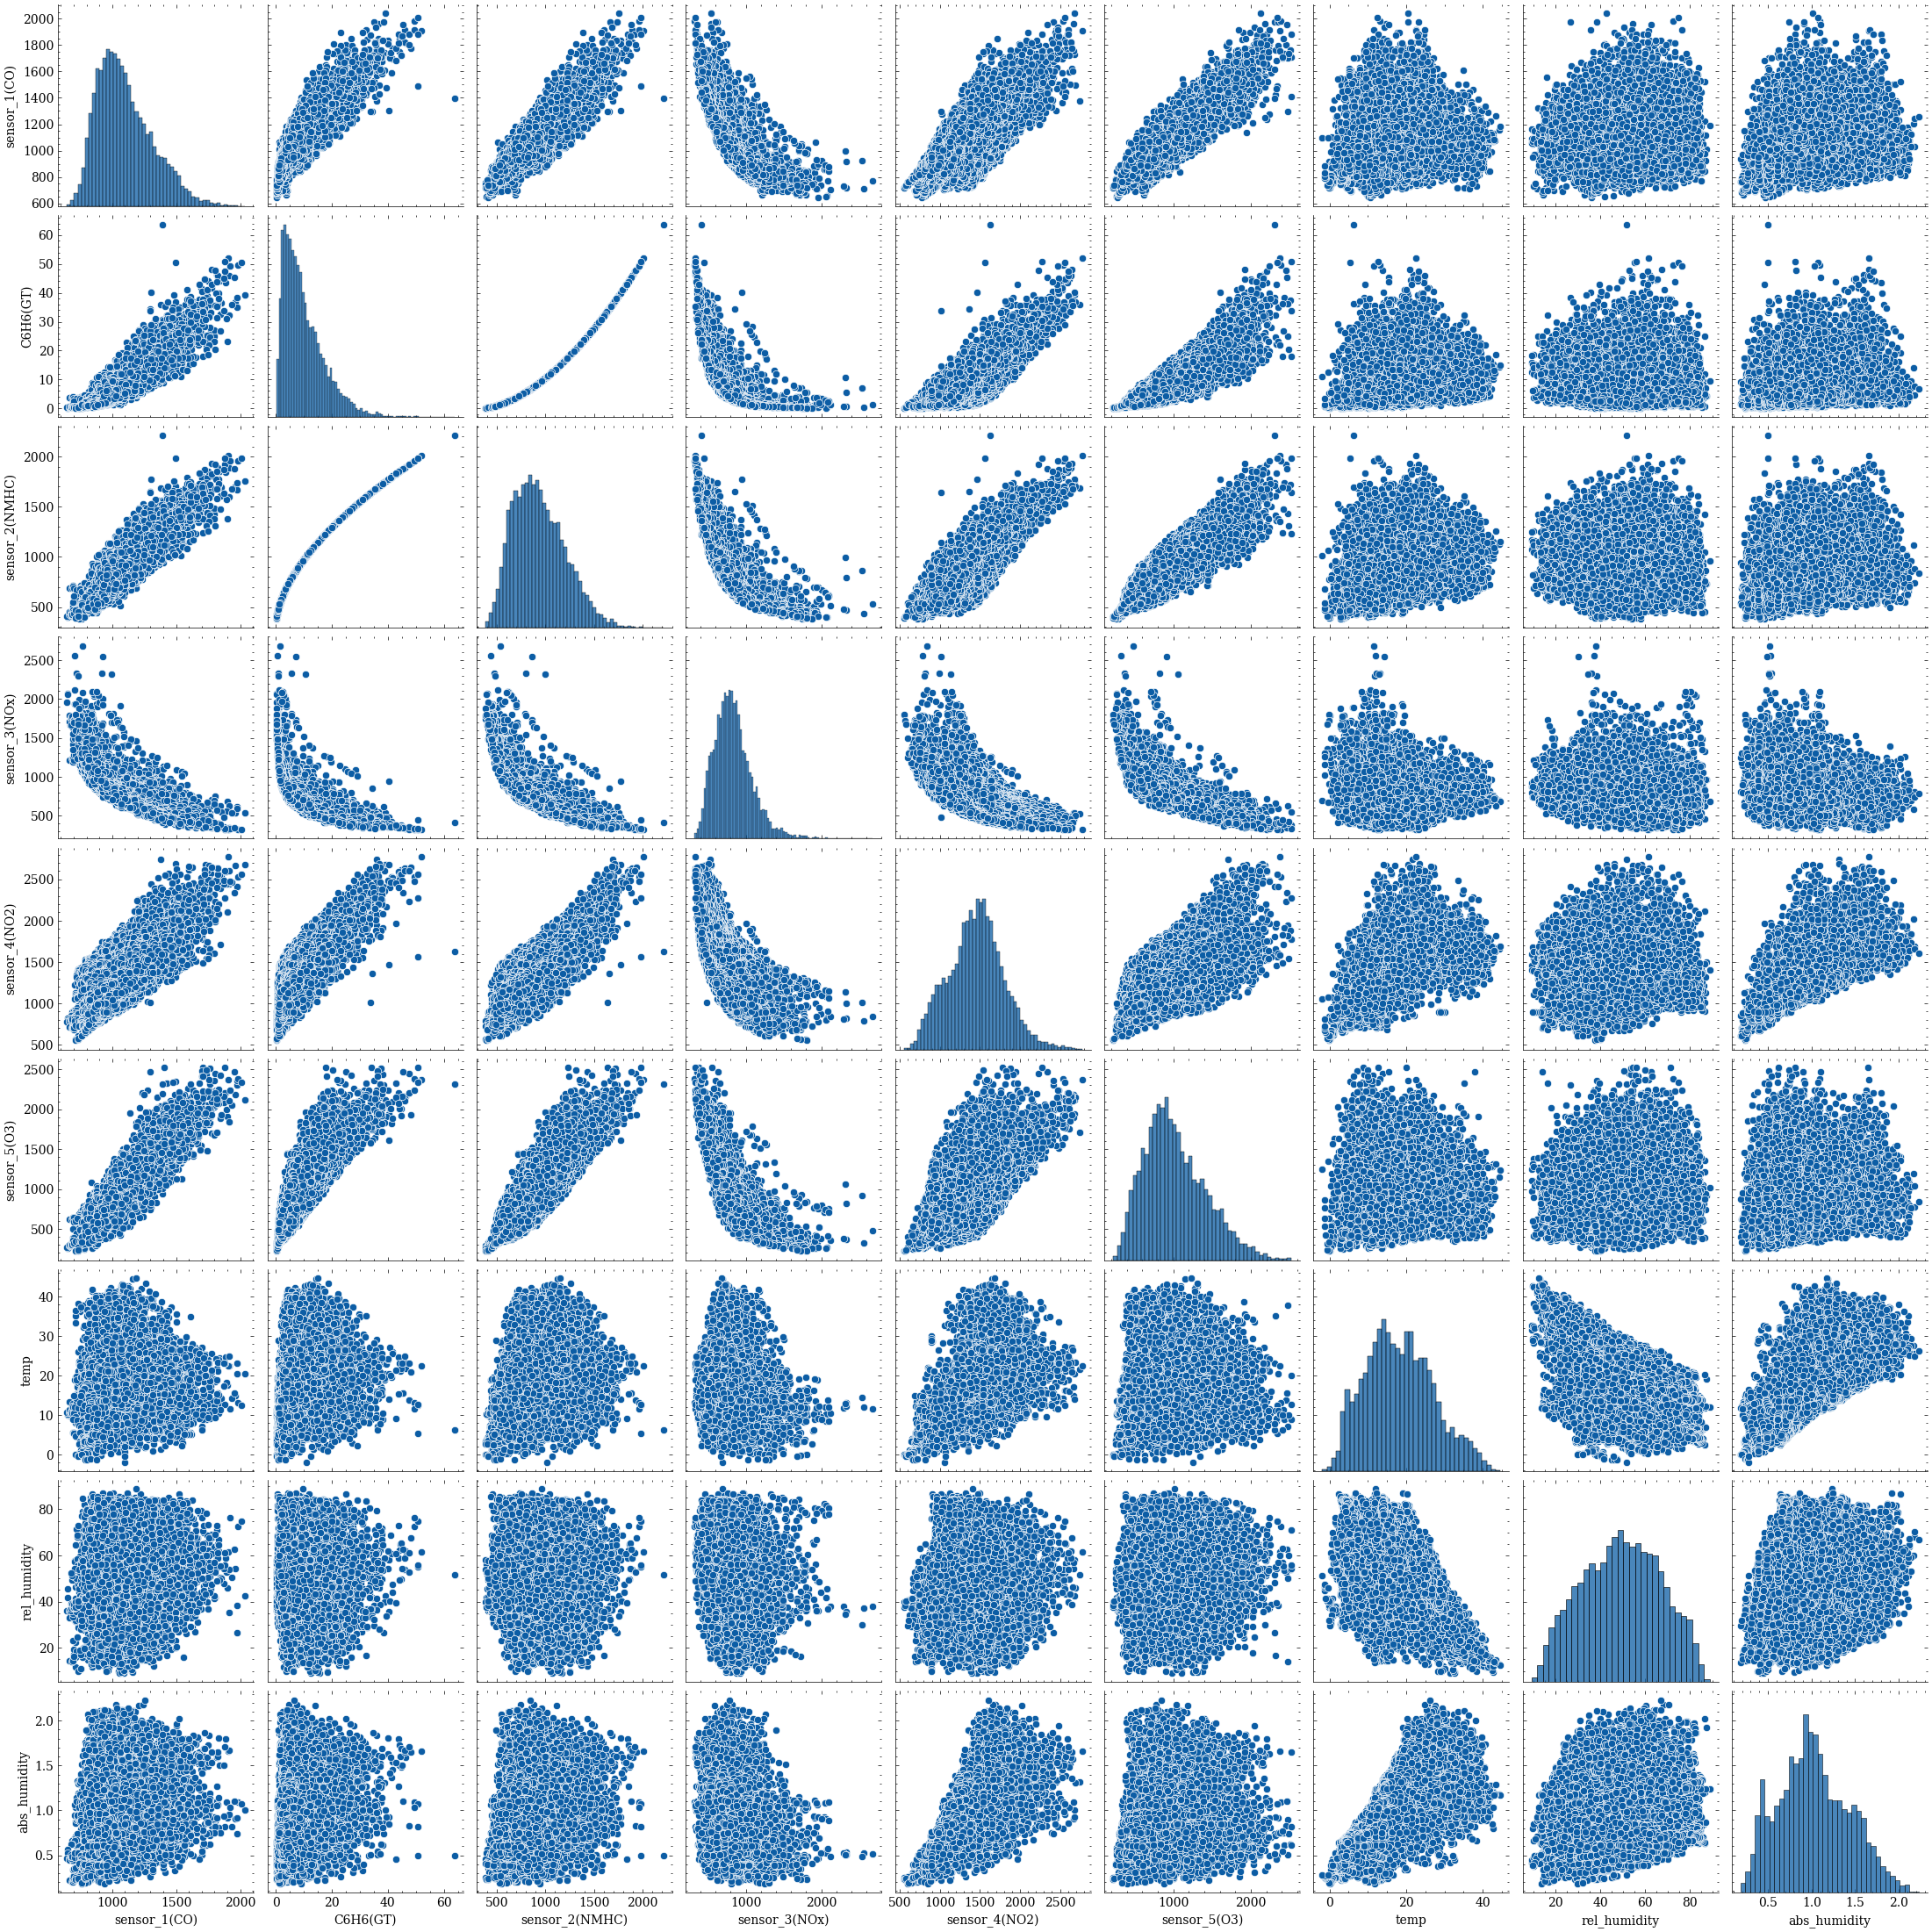

In [19]:
#now let us recheck the distributions of our data now
sns.pairplot(df)

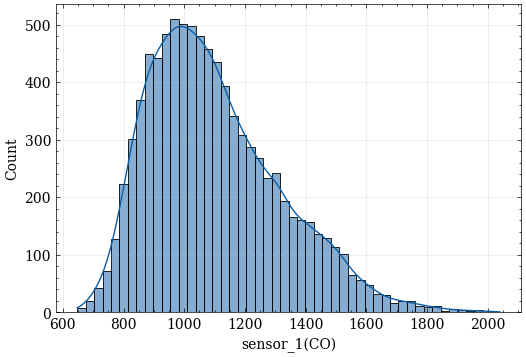

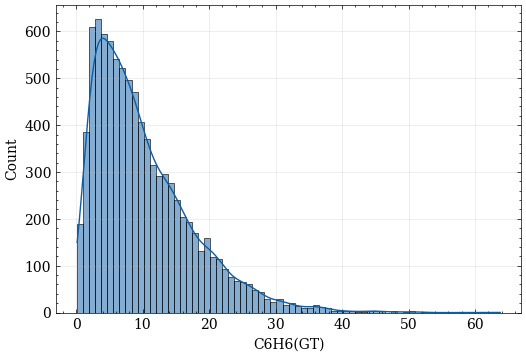

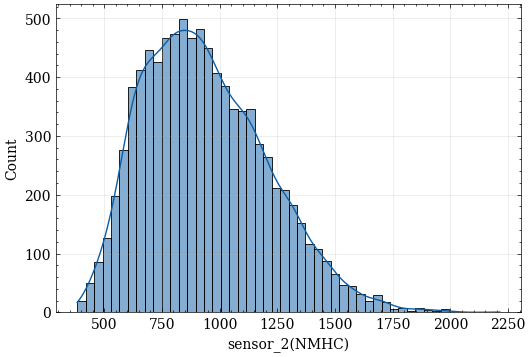

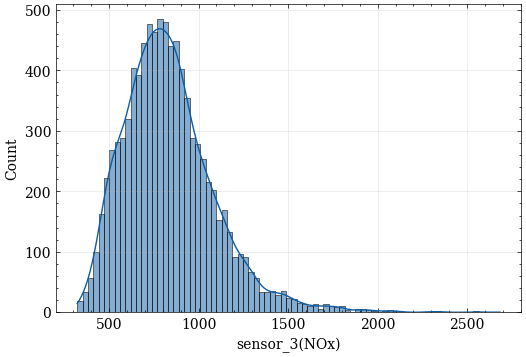

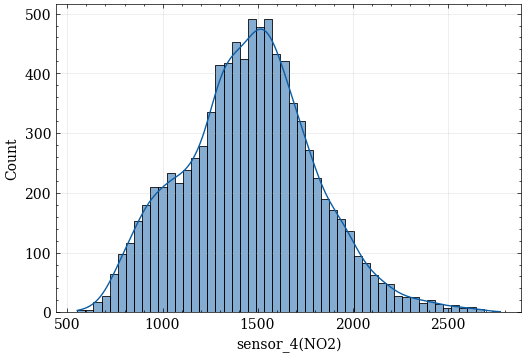

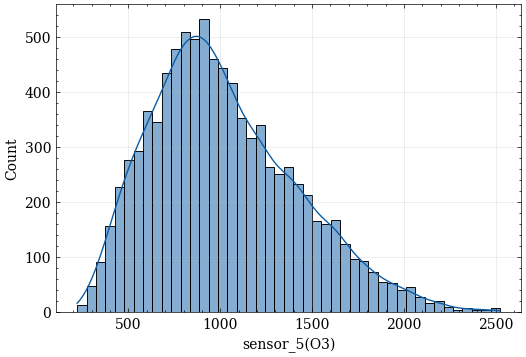

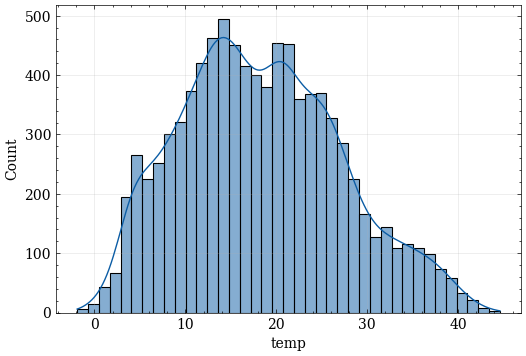

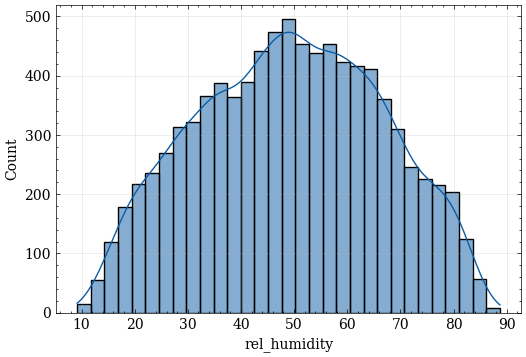

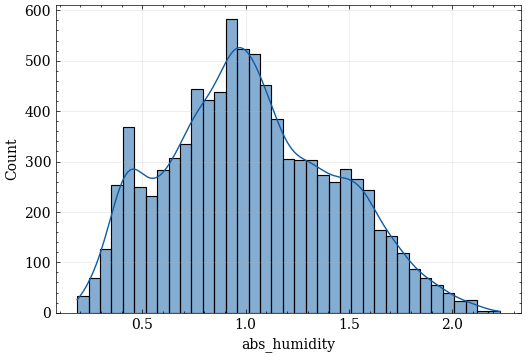

In [20]:
for column in df.drop(columns=["date","time"]):
    plot_histplot(column)

#### Correlations between sensor readings and target

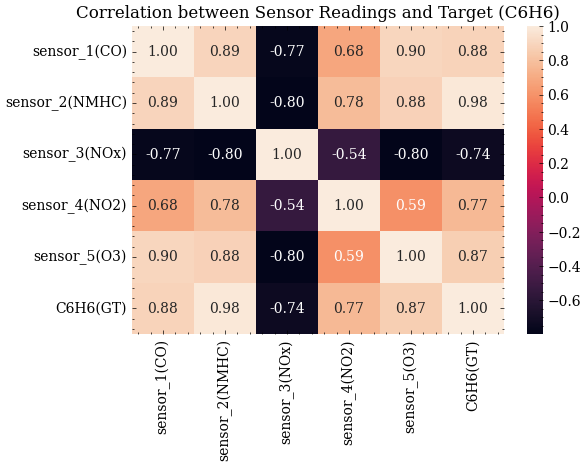

In [291]:
#these are the estimations from the sensor readings
sensor_reading = ["sensor_1(CO)","sensor_2(NMHC)","sensor_3(NOx)","sensor_4(NO2)","sensor_5(O3)"]


plt.figure(figsize=(6,4))
sns.heatmap(df[sensor_reading +['C6H6(GT)']].corr(), annot= True, fmt= '.2f')
plt.title("Correlation between Sensor Readings and Target (C6H6)")
#plt.axis('off')
plt.show()

### Feature Extraction
---
We will be extracting some features from the time since this is a time series data.


In [22]:
#We will use the date as our index
df['datetime'] = pd.to_datetime(df['date'].astype(str) + ' ' + df['time'].astype(str))
df.set_index("datetime", inplace= True)
df.head()

date      time  sensor_1(CO)   C6H6(GT)  \
datetime                                                            
2004-03-10 18:00:00 2004-03-10  18:00:00       1360.00  11.881723   
2004-03-10 19:00:00 2004-03-10  19:00:00       1292.25   9.397165   
2004-03-10 20:00:00 2004-03-10  20:00:00       1402.00   8.997817   
2004-03-10 21:00:00 2004-03-10  21:00:00       1375.50   9.228796   
2004-03-10 22:00:00 2004-03-10  22:00:00       1272.25   6.518224   

                     sensor_2(NMHC)  sensor_3(NOx)  sensor_4(NO2)  \
datetime                                                            
2004-03-10 18:00:00         1045.50        1056.25        1692.00   
2004-03-10 19:00:00          954.75        1173.75        1558.75   
2004-03-10 20:00:00          939.25        1140.00        1554.50   
2004-03-10 21:00:00          948.25        1092.00        1583.75   
2004-03-10 22:00:00          835.50        1205.00        1490.00   

                     sensor_5(O3)   temp  rel_humidity  abs_humidity  
datetime                                                              
2004-03-10 18:00:00       1267.50  13.60     48.875001      0.757754  
2004-03-10 19:00:00        972.25  13.30     47.700000      0.725487  
2004-03-10 20:00:00       1074.00  11.90     53.975000      0.750239  
2004-03-10 21:00:00       1203.25  11.00     60.000000      0.786713  
2004-03-10 22:00:00       1110.00  11.15     59.575001      0.788794

In [23]:
# Datetime feature extraction from time

df["day_of_week"] = df.index.day_of_week
df["month"] = df.index.month
df["day_name"] = df.index.day_name()
df["month_name"] = df.index.month_name()
df['hour'] = df.index.hour

df.head()



date      time  sensor_1(CO)   C6H6(GT)  \
datetime                                                            
2004-03-10 18:00:00 2004-03-10  18:00:00       1360.00  11.881723   
2004-03-10 19:00:00 2004-03-10  19:00:00       1292.25   9.397165   
2004-03-10 20:00:00 2004-03-10  20:00:00       1402.00   8.997817   
2004-03-10 21:00:00 2004-03-10  21:00:00       1375.50   9.228796   
2004-03-10 22:00:00 2004-03-10  22:00:00       1272.25   6.518224   

                     sensor_2(NMHC)  sensor_3(NOx)  sensor_4(NO2)  \
datetime                                                            
2004-03-10 18:00:00         1045.50        1056.25        1692.00   
2004-03-10 19:00:00          954.75        1173.75        1558.75   
2004-03-10 20:00:00          939.25        1140.00        1554.50   
2004-03-10 21:00:00          948.25        1092.00        1583.75   
2004-03-10 22:00:00          835.50        1205.00        1490.00   

                     sensor_5(O3)   temp  rel_humidity  abs_humidity  \
datetime                                                               
2004-03-10 18:00:00       1267.50  13.60     48.875001      0.757754   
2004-03-10 19:00:00        972.25  13.30     47.700000      0.725487   
2004-03-10 20:00:00       1074.00  11.90     53.975000      0.750239   
2004-03-10 21:00:00       1203.25  11.00     60.000000      0.786713   
2004-03-10 22:00:00       1110.00  11.15     59.575001      0.788794   

                     day_of_week  month   day_name month_name  hour  
datetime                                                             
2004-03-10 18:00:00            2      3  Wednesday      March    18  
2004-03-10 19:00:00            2      3  Wednesday      March    19  
2004-03-10 20:00:00            2      3  Wednesday      March    20  
2004-03-10 21:00:00            2      3  Wednesday      March    21  
2004-03-10 22:00:00            2      3  Wednesday      March    22

In [351]:
some_features = "sensor_1(CO)	C6H6(GT)	sensor_2(NMHC)	sensor_3(NOx)	sensor_4(NO2)	sensor_5(O3)	temp	rel_humidity	abs_humidity".split("	")	
df[some_features].describe().to_csv(r"C:\Users\Administrator\OneDrive\Desktop\Masters\7153 CEM Modeling and Optimisation Under Uncertainty\Course Work Folder\code\desc_stat.csv")

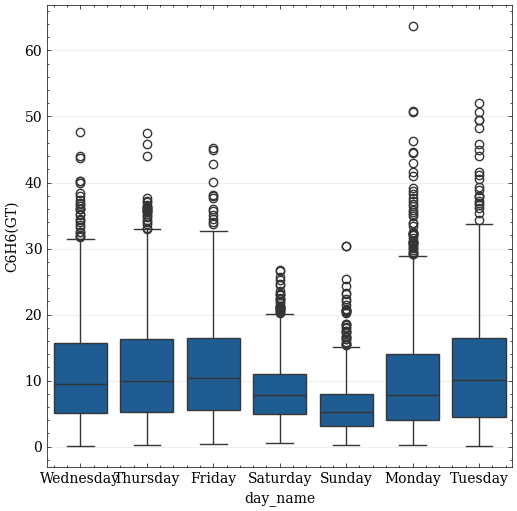

In [24]:
plt.figure(figsize = (6,6))
sns.boxplot(data = df, x = "day_name", y = "C6H6(GT)")
plt.grid(alpha= 0.3,axis= 'y')
plt.show()

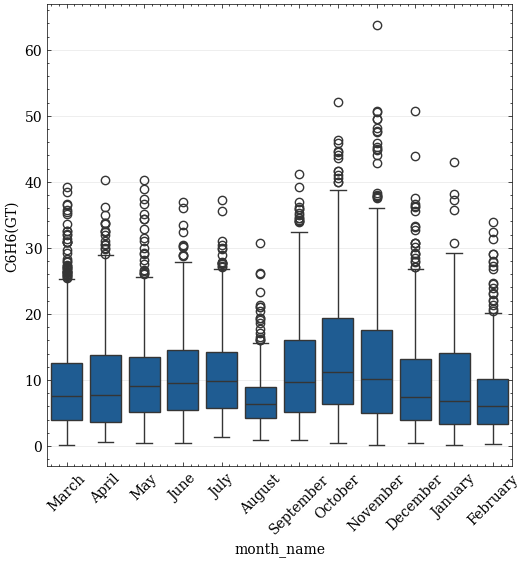

In [25]:
plt.figure(figsize = (6,6))
sns.boxplot(data = df, x = "month_name", y = "C6H6(GT)")
plt.xticks(rotation = 45) #August is the main Italian vacation month in Italy which is possibly why the benzene concentrations fall down dramatically
plt.grid(alpha= 0.3,axis= 'y')
plt.show()

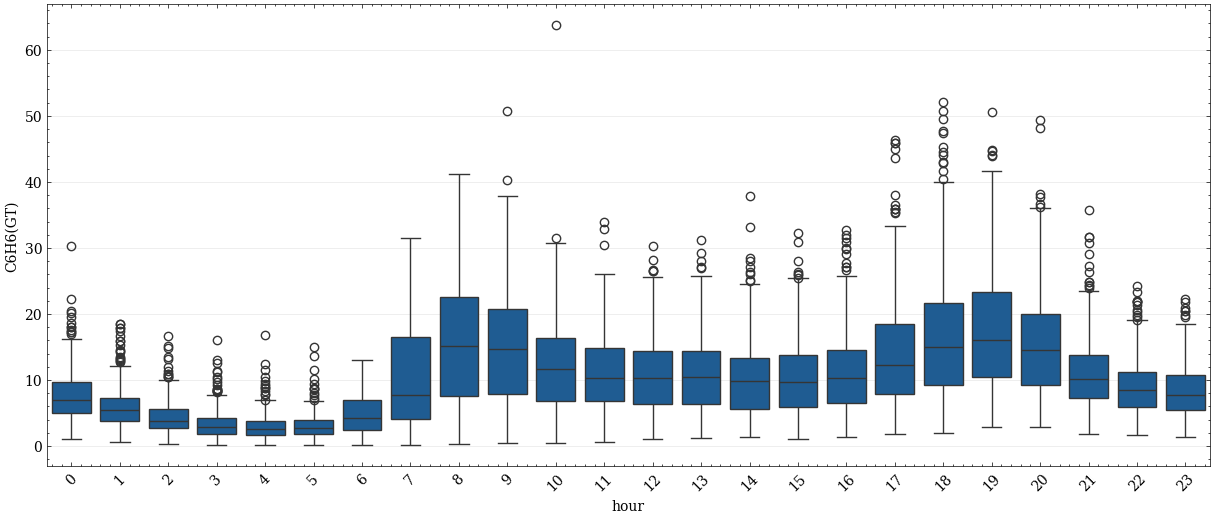

In [26]:
plt.figure(figsize= (15,6))
sns.boxplot(data = df, x = "hour", y = "C6H6(GT)")
plt.xticks(rotation = 45)
plt.grid(alpha= 0.3,axis= 'y')
plt.show()


## 4. Splitting dataset for training and testing
---

In [233]:
#since it is a time series data we must split by date
train = df.loc[df.index<'2004-12-01'].copy()
test = df.loc[df.index>='2004-12-01'].copy()

print(f"The shape of our train data is {train.shape}")
print(f"The shape of our test data is{test.shape}")

The shape of our train data is (6218, 16)
The shape of our test data is(2773, 16)


In [28]:
train.head() # I only added day name, month_name and hour just for analysis sake an they will be dropped you have to remove time

date      time  sensor_1(CO)   C6H6(GT)  \
datetime                                                            
2004-03-10 18:00:00 2004-03-10  18:00:00       1360.00  11.881723   
2004-03-10 19:00:00 2004-03-10  19:00:00       1292.25   9.397165   
2004-03-10 20:00:00 2004-03-10  20:00:00       1402.00   8.997817   
2004-03-10 21:00:00 2004-03-10  21:00:00       1375.50   9.228796   
2004-03-10 22:00:00 2004-03-10  22:00:00       1272.25   6.518224   

                     sensor_2(NMHC)  sensor_3(NOx)  sensor_4(NO2)  \
datetime                                                            
2004-03-10 18:00:00         1045.50        1056.25        1692.00   
2004-03-10 19:00:00          954.75        1173.75        1558.75   
2004-03-10 20:00:00          939.25        1140.00        1554.50   
2004-03-10 21:00:00          948.25        1092.00        1583.75   
2004-03-10 22:00:00          835.50        1205.00        1490.00   

                     sensor_5(O3)   temp  rel_humidity  abs_humidity  \
datetime                                                               
2004-03-10 18:00:00       1267.50  13.60     48.875001      0.757754   
2004-03-10 19:00:00        972.25  13.30     47.700000      0.725487   
2004-03-10 20:00:00       1074.00  11.90     53.975000      0.750239   
2004-03-10 21:00:00       1203.25  11.00     60.000000      0.786713   
2004-03-10 22:00:00       1110.00  11.15     59.575001      0.788794   

                     day_of_week  month   day_name month_name  hour  
datetime                                                             
2004-03-10 18:00:00            2      3  Wednesday      March    18  
2004-03-10 19:00:00            2      3  Wednesday      March    19  
2004-03-10 20:00:00            2      3  Wednesday      March    20  
2004-03-10 21:00:00            2      3  Wednesday      March    21  
2004-03-10 22:00:00            2      3  Wednesday      March    22

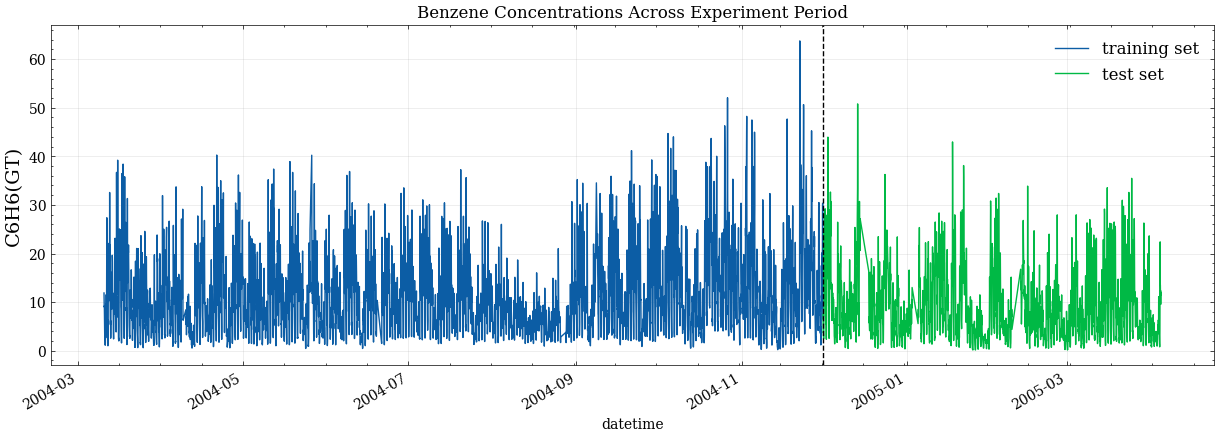

In [29]:

fig, ax = plt.subplots(figsize = (15,5))
train["C6H6(GT)"].plot(ax=ax, label = "training set")
test["C6H6(GT)"].plot(ax=ax, label = 'test set')
ax.axvline('2004-12-01', color = 'black', ls = '--')
plt.grid(alpha = 0.3)
plt.ylabel("C6H6(GT)", fontsize = 14)
plt.title("Benzene Concentrations Across Experiment Period")
plt.legend(fontsize = 12)
plt.show()

In [30]:
train

date      time  sensor_1(CO)   C6H6(GT)  \
datetime                                                            
2004-03-10 18:00:00 2004-03-10  18:00:00   1360.000000  11.881723   
2004-03-10 19:00:00 2004-03-10  19:00:00   1292.250000   9.397165   
2004-03-10 20:00:00 2004-03-10  20:00:00   1402.000000   8.997817   
2004-03-10 21:00:00 2004-03-10  21:00:00   1375.500000   9.228796   
2004-03-10 22:00:00 2004-03-10  22:00:00   1272.250000   6.518224   
...                        ...       ...           ...        ...   
2004-11-30 19:00:00 2004-11-30  19:00:00   1408.333333  27.960645   
2004-11-30 20:00:00 2004-11-30  20:00:00   1471.250000  30.347901   
2004-11-30 21:00:00 2004-11-30  21:00:00   1157.250000  12.396477   
2004-11-30 22:00:00 2004-11-30  22:00:00   1061.000000   8.001629   
2004-11-30 23:00:00 2004-11-30  23:00:00   1005.500000   6.534919   

                     sensor_2(NMHC)  sensor_3(NOx)  sensor_4(NO2)  \
datetime                                                            
2004-03-10 18:00:00     1045.500000        1056.25        1692.00   
2004-03-10 19:00:00      954.750000        1173.75        1558.75   
2004-03-10 20:00:00      939.250000        1140.00        1554.50   
2004-03-10 21:00:00      948.250000        1092.00        1583.75   
2004-03-10 22:00:00      835.500000        1205.00        1490.00   
...                             ...            ...            ...   
2004-11-30 19:00:00     1502.333333         640.00        1843.00   
2004-11-30 20:00:00     1559.000000         605.25        1938.75   
2004-11-30 21:00:00     1063.250000         905.25        1394.00   
2004-11-30 22:00:00      899.250000        1067.25        1276.50   
2004-11-30 23:00:00      836.250000        1226.00        1209.75   

                     sensor_5(O3)       temp  rel_humidity  abs_humidity  \
datetime                                                                   
2004-03-10 18:00:00       1267.50  13.600000     48.875001      0.757754   
2004-03-10 19:00:00        972.25  13.300000     47.700000      0.725487   
2004-03-10 20:00:00       1074.00  11.900000     53.975000      0.750239   
2004-03-10 21:00:00       1203.25  11.000000     60.000000      0.786713   
2004-03-10 22:00:00       1110.00  11.150000     59.575001      0.788794   
...                           ...        ...           ...           ...   
2004-11-30 19:00:00       1598.00  11.633333     64.333332      0.878923   
2004-11-30 20:00:00       1668.50  11.500000     67.975000      0.920689   
2004-11-30 21:00:00       1223.00  10.700000     73.899998      0.950224   
2004-11-30 22:00:00        939.00   9.550000     83.000000      0.989861   
2004-11-30 23:00:00        901.75   9.625000     79.925001      0.957896   

                     day_of_week  month   day_name month_name  hour  
datetime                                                             
2004-03-10 18:00:00            2      3  Wednesday      March    18  
2004-03-10 19:00:00            2      3  Wednesday      March    19  
2004-03-10 20:00:00            2      3  Wednesday      March    20  
2004-03-10 21:00:00            2      3  Wednesday      March    21  
2004-03-10 22:00:00            2      3  Wednesday      March    22  
...                          ...    ...        ...        ...   ...  
2004-11-30 19:00:00            1     11    Tuesday   November    19  
2004-11-30 20:00:00            1     11    Tuesday   November    20  
2004-11-30 21:00:00            1     11    Tuesday   November    21  
2004-11-30 22:00:00            1     11    Tuesday   November    22  
2004-11-30 23:00:00            1     11    Tuesday   November    23  

[6218 rows x 16 columns]

## 5. Application of Machine Learning Models and Gaussian Process Regression

In [31]:
df.columns

Index(['date', 'time', 'sensor_1(CO)', 'C6H6(GT)', 'sensor_2(NMHC)',
       'sensor_3(NOx)', 'sensor_4(NO2)', 'sensor_5(O3)', 'temp',
       'rel_humidity', 'abs_humidity', 'day_of_week', 'month', 'day_name',
       'month_name', 'hour'],
      dtype='object')

In [32]:
features =['sensor_1(CO)','sensor_2(NMHC)','sensor_3(NOx)','sensor_4(NO2)',
           'sensor_5(O3)','temp','rel_humidity','abs_humidity','day_of_week','month']

target = ['C6H6(GT)']
X_train = train[features]
X_test = test[features]
y_train = train[target]
y_test = test[target]

In [ ]:
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)


### 5.1 Linear Regression
---
This is our baseline model

In [355]:
lr = LinearRegression()
lr.fit(X_train_sc,y_train)

lr_pred = lr.predict(X_test_sc)

#Evaluation of Linear regression
lr_mse = mean_squared_error(y_test,lr_pred)
lr_r2 = r2_score(y_test,lr_pred)
print(f"The Mean squared error for linear regression is {lr_mse:.3f}")
print(f"The r2 score for linear regression is {lr_r2:.3f}")

The Mean squared error for linear regression is 9.827
The r2 score for linear regression is 0.788


### 5.2 Random Forest Regressor
---


In [341]:
rfr =  RandomForestRegressor(random_state= 70)
rfr.fit(X_train_sc,y_train)
rfr_pred = rfr.predict(X_test_sc)

rfr_mse = mean_squared_error(y_test,rfr_pred) 
rfr_r2 = r2_score(y_test,rfr_pred)
print(f"The Mean squared error for Random Forest regressor is {rfr_mse:.3f}")

print(f"The r2 score fpr Random Forest regressor is {rfr_r2:.3f}")

c:\Users\Administrator\anaconda3\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


The Mean squared error for Random Forest regressor is 5.472
The r2 score fpr Random Forest regressor is 0.882


### 5.3 Support Vector Machine

In [332]:
svr = SVR(kernel= 'rbf')#kernel= optimized_params["kernel"])
svr.fit(X_train_sc,y_train)
svr_pred = svr.predict(X_test_sc)
svr_mse = mean_squared_error(y_test,svr_pred) 
svr_r2 = r2_score(y_test,svr_pred)

print(f"The Mean squared error for Support Vector Machine is {svr_mse:.3f}")
print(f"The r2 score for Support Vector Machine is {svr_r2:.3f}")

c:\Users\Administrator\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


The Mean squared error for Support Vector Machine is 6.891
The r2 score for Support Vector Machine is 0.851


### 5.4 Gaussian Process Regression

In [ ]:

# alpha- this is the noise level
kernel = RBF() + WhiteKernel()
gpr = GaussianProcessRegressor(kernel=kernel, alpha=1e-6, n_restarts_optimizer=10,  random_state=42) #this is the one that I am using
gpr.fit(X_train_sc,y_train)
gpr1_pred,sigma_1 = gpr.predict(X_test_sc, return_std= True)

gpr1_mse = mean_squared_error(y_test, gpr1_pred)
gpr1_r2 = r2_score(y_test, gpr1_pred)

#print evaluation metrics
print(f"The Mean square error for Gaussian Process Regression is {gpr1_mse:.3f}")
print(f"The r2_score for Gaussian Process Regression is {gpr1_r2:.3f}")

The Mean square error for Gaussian Process Regression is 5.429
The r2_score for Gaussian Process Regression is 0.883


###  5.5 Gridsearch for Gaussian Process Regression

In [ ]:
#gridsearch

param_grid = {
    'kernel': [
        RBF() + WhiteKernel(),  # my current kernel
        ConstantKernel() * RBF() + WhiteKernel(),  # add scaling factor
    ],
    'alpha': [1e-10, 1e-8],
    'n_restarts_optimizer': [5, 10]  #number of restarts
}   
tscv = TimeSeriesSplit(n_splits=5)


# Create GridSearchCV object
gpr_grid = GridSearchCV(
    estimator=GaussianProcessRegressor(random_state=42),
    param_grid=param_grid,
    cv=tscv,  # 5-fold cross-validation
    scoring='neg_mean_squared_error',  #'neg_root_mean_squared_error', 'r2'
    verbose=1,
    n_jobs=3  # Use three of my cores
)

# Fit the grid search
gpr_grid.fit(X_train_sc, y_train)

# Get best_params = gpr_grid.best_params_best parameters and best model
best_params = gpr_grid.best_params_
best_gpr = gpr_grid.best_estimator_

# Print results
print("Best parameters:", best_params)
print("Best CV score:", -gpr_grid.best_score_)  # Convert back from negative

# Make predictions with best model
y_pred = best_gpr.predict(X_test_sc)
#454 minutes


Fitting 5 folds for each of 8 candidates, totalling 40 fits


c:\Users\Administrator\anaconda3\Lib\site-packages\sklearn\gaussian_process\_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
c:\Users\Administrator\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Best parameters: {'alpha': 1e-10, 'kernel': 1**2 * RBF(length_scale=1) + WhiteKernel(noise_level=1), 'n_restarts_optimizer': 5}
Best CV score: 0.00014349893410037706


#### 5.5.1 Training After Grid Search

In [ ]:
#Due to the large training time of the grid search
# I have to save the model
dump(gpr_grid, 'guassian_grid_search.pkl')

['guassian_grid_search.pkl']

In [ ]:
optimized_params = {'alpha': 1e-10, 'kernel': 1**2 * RBF(length_scale=1) 
                    + WhiteKernel(noise_level=1), 'n_restarts_optimizer': 5}

In [ ]:
# create new model
gpr_best = GaussianProcessRegressor(kernel=optimized_params["kernel"], alpha=optimized_params["alpha"]
                                    , n_restarts_optimizer= optimized_params['n_restarts_optimizer'], random_state= 70)
#fit model an all training data
gpr_best.fit(X_train_sc, y_train)
gpr2_pred, sigma_2  = gpr_best.predict(X_test_sc, return_std= True)


gpr2_mse = mean_squared_error(y_test, gpr2_pred)
gpr2_r2 = r2_score(y_test,gpr2_pred)
#print evaluation metrics
print(f"The Mean square error for Gaussian Process Regression (grid_search) is {gpr2_mse:.3f}")
print(f"The r2 score for Gaussian Process Regression (grid_search) is {gpr2_r2:.3f}")


c:\Users\Administrator\anaconda3\Lib\site-packages\sklearn\gaussian_process\_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
c:\Users\Administrator\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


GaussianProcessRegressor(kernel=1**2 * RBF(length_scale=1) + WhiteKernel(noise_level=1),
                         n_restarts_optimizer=5, random_state=70)

In [235]:
#lets add our prediction to the test dataset for visualisation
test["prediction_gpr1"] = gpr1_pred
test["prediction_gpr2"] = gpr2_pred

In [308]:
#test[["C6H6(GT)","prediction_gpr1" ,"prediction_gpr2"]]
#best parameters for the grid search
best_params = gpr_grid.best_params_

In [360]:
gpr.kernel_

RBF(length_scale=3.96) + WhiteKernel(noise_level=1e-05)

In [354]:
gpr_periodic.fit(X_train_sc, y_train)

GaussianProcessRegressor(kernel=ExpSineSquared(length_scale=1, periodicity=3),
                         n_restarts_optimizer=10, random_state=70)

In [356]:
gpr_rbf3, sigma_3  = gpr_rbf.predict(X_test_sc, return_std= True)
gpr_peri, sigma_4  = gpr_periodic.predict(X_test_sc, return_std= True)

In [358]:
mean_squared_error(y_test, gpr_rbf3)
#mean_squared_error(y_test, gpr_peri)

5.452685713532403

## 6. Evaluation Metrics

#### 6.1 Mean_Squared_Error

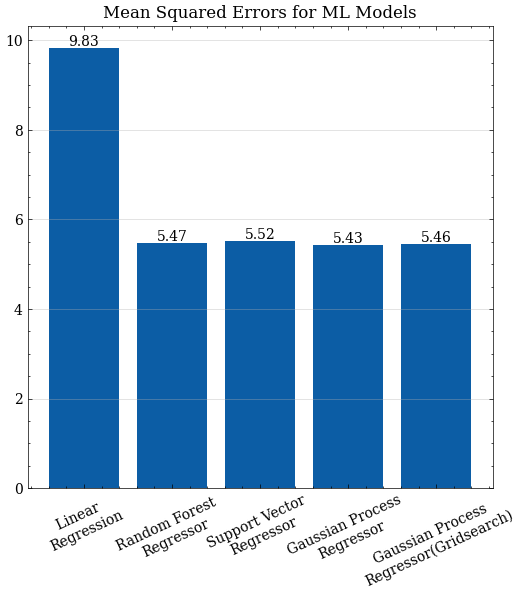

In [ ]:
list_of_mses = [lr_mse,rfr_mse,svr_mse, gpr1_mse, gpr2_mse]
 
labels = ["Linear \nRegression","Random Forest \nRegressor","Support Vector\nRegressor","Gaussian Process\nRegressor","Gaussian Process \nRegressor(Gridsearch)"]

plt.figure(figsize=(6,6))
plt.bar(labels,list_of_mses)
for index, value in enumerate(list_of_mses):
    plt.text(index, value+0.05,f'{float(value):.2f}', ha = 'center', fontsize = 10)
plt.grid(True, axis='y', alpha = 0.5)
plt.title("Mean Squared Errors for ML Models")
plt.xticks(rotation=25)
plt.show()


#### 6.2 $R^2$ 

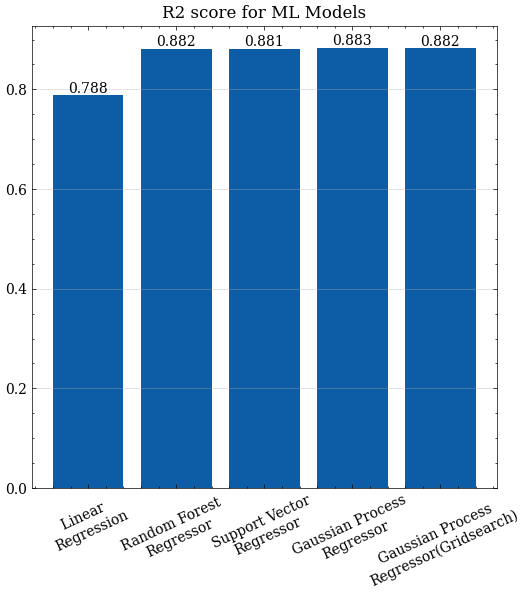

In [319]:
list_of_r2s = [lr_r2,rfr_r2,svr_r2, gpr1_r2, gpr2_r2]
 
labels = ["Linear \nRegression","Random Forest \nRegressor","Support Vector\nRegressor","Gaussian Process\nRegressor","Gaussian Process \nRegressor(Gridsearch)"]

plt.figure(figsize=(6,6))
plt.bar(labels,list_of_r2s)
for index, value in enumerate(list_of_r2s):
    plt.text(index, value+0.00625,f'{float(value):.3f}', ha = 'center', fontsize = 10)
plt.grid(True, axis='y', alpha = 0.5)
plt.title("R2 score for ML Models")
plt.xticks(rotation=25)
plt.show()


### 6.3 Root Mean Squared

In [ ]:
from sklearn.metrics import root_mean_squared_error
lr_rmse =root_mean_squared_error(y_test, lr_pred)
rfr_rmse =root_mean_squared_error(y_test, rfr_pred)
svr_rmse =root_mean_squared_error(y_test, svr_pred)
gpr1_rmse =root_mean_squared_error(y_test, gpr1_pred)
gpr2_rmse =root_mean_squared_error(y_test, gpr2_pred)

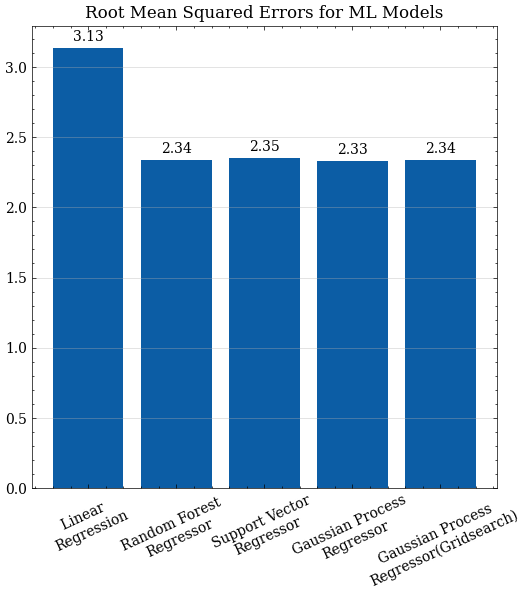

In [ ]:
list_of_rmses = [lr_rmse,rfr_rmse,svr_rmse, gpr1_rmse, gpr2_rmse]
 
labels = ["Linear \nRegression","Random Forest \nRegressor","Support Vector\nRegressor","Gaussian Process\nRegressor","Gaussian Process \nRegressor(Gridsearch)"]

plt.figure(figsize=(6,6))
plt.bar(labels,list_of_rmses)
for index, value in enumerate(list_of_rmses):
    plt.text(index, value+0.05,f'{float(value):.2f}', ha = 'center', fontsize = 10)
plt.grid(True, axis='y', alpha = 0.5)
plt.title("Root Mean Squared Errors for ML Models")
plt.xticks(rotation=25)
plt.show()



## 7. Plots for Reports
---
These plots are strictly for the best model which is the gaussian process regressor without grid search

### 7.1 Train Test Split

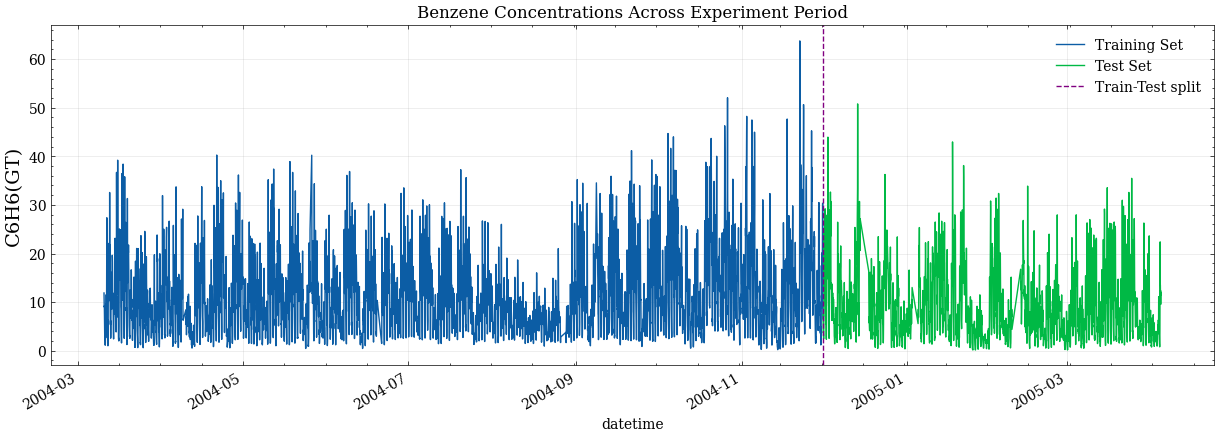

In [ ]:
#Gpr without grid_search
#This is to show the train test split

fig, ax = plt.subplots(figsize = (15,5))
train["C6H6(GT)"].plot(ax=ax, label = "Training Set")
test["C6H6(GT)"].plot(ax=ax, label = 'Test Set')
#test["prediction_gpr1"].plot(ax=ax,label='pred')
'''ax.fill_between(test.index, 
                test["prediction_gpr1"] - 1.96* sigma_1, 
                test["prediction_gpr1"] + 1.96* sigma_1, 
                color="red", alpha=0.2, label="Confidence Interval")
'''
ax.axvline('2004-12-01', color = 'purple', ls = '--', label = 'Train-Test split')
plt.grid(alpha = 0.3)
plt.ylabel("C6H6(GT)", fontsize = 14)
plt.title("Benzene Concentrations Across Experiment Period")
plt.legend(fontsize = 10)
plt.show()

### 7.2 predictions and confidence intervals.

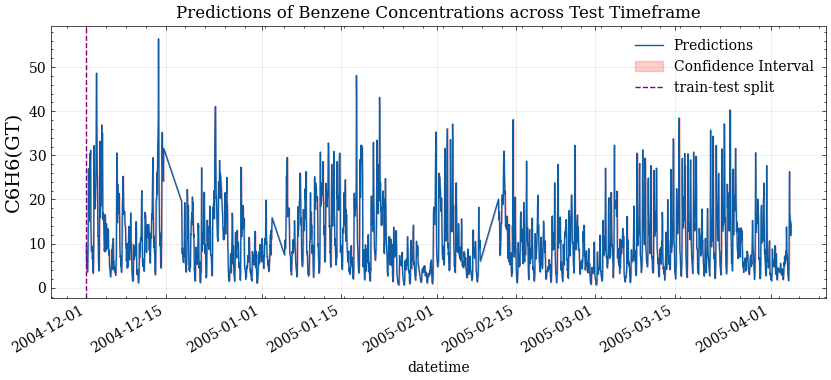

In [367]:
#For GPR1 pred

fig, ax = plt.subplots(figsize = (10,4))
#train["C6H6(GT)"].plot(ax=ax, label = "Training Set")
#test["C6H6(GT)"].plot(ax=ax, label = 'Test Set')
test["prediction_gpr1"].plot(ax=ax,label='Predictions')
ax.fill_between(test.index,  
                test["prediction_gpr1"] + 1.96* sigma_1,
                test["prediction_gpr1"] - 1.96* sigma_1, 
                color="red", alpha=0.2, label="Confidence Interval")

ax.axvline('2004-12-01', color = 'purple', ls = '--', label = 'train-test split')
plt.grid(alpha = 0.3)
plt.ylabel("C6H6(GT)", fontsize = 14)
plt.title("Predictions of Benzene Concentrations across Test Timeframe")
plt.legend(fontsize = 10)
plt.show()

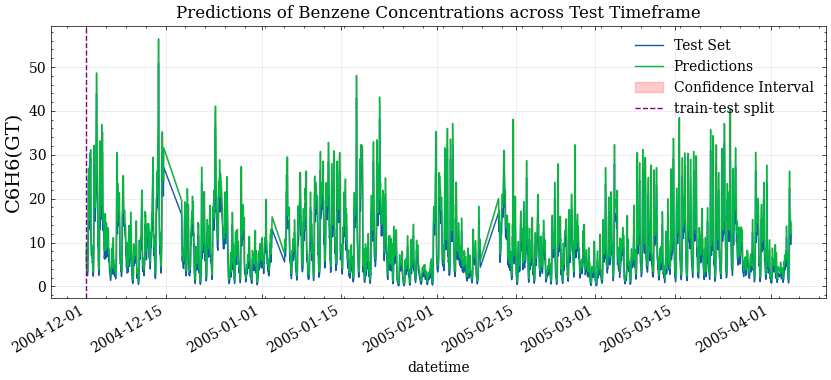

In [ ]:
#For GPR1 pred

fig, ax = plt.subplots(figsize = (10,4))
#train["C6H6(GT)"].plot(ax=ax, label = "Training Set")
test["C6H6(GT)"].plot(ax=ax, label = 'Test Set')
test["prediction_gpr1"].plot(ax=ax,label='Predictions')
ax.fill_between(test.index,  
                test["prediction_gpr1"] + 1.96* sigma_1,
                test["prediction_gpr1"] - 1.96* sigma_1, 
                color="red", alpha=0.2, label="Confidence Interval")

ax.axvline('2004-12-01', color = 'purple', ls = '--', label = 'train-test split')
plt.grid(alpha = 0.3)
plt.ylabel("C6H6(GT)", fontsize = 14)
plt.title("Predictions vs Actual Benzene Concentrations across Test Timeframe")
plt.legend(fontsize = 10)
plt.show()

In [380]:
#sns.catplot(data = test,y=test["C6H6(GT)"],x=test.index)